# Across-subject testing with [GLHMM toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we demonstrate how to implement the Across-subjects test using the [GLHMM toolbox](https://github.com/vidaurre/glhmm), part of the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). This test is designed to evaluate relationships between brain states and behavioral traits and is useful for exploring individual differences among people.

For this tutorial, we use data from the Human Connectome Project (HCP) S1200 Young Adult dataset ([van Essen et al., 2013](https://pmc.ncbi.nlm.nih.gov/articles/PMC3724347/)). The HCP dataset provides a real-world context for this analysis, offering detailed information about subjects, including demographic and behavioral traits such as sex and age.

**Note: Access to HCP data requires permission. If you have not yet applied for access, follow the instructions [here](https://db.humanconnectome.org/) to request permission.**

In this setup:

* The brain data ($D$) consists of aggregated HMM-related statistics, such as fractional occupancies (FO).
* The behavioral measures ($R$) include variables such as sex and age.
The goal is to assess the relationship between brain data ($D$) and behavioral traits ($R$) using permutation testing.

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/Testing_across_subjects.ipynb).

Authors: Nick Yao Larsen <nylarsen@cfin.au.dk>

## Table of Contents
1. [Load and prepare data](#load-data)
    * [HMM-aggregated statistics](#fam-struc2)
2. [Across-subjects testing](#across_subjects)
    * [Family structure](#fam-struc)
    * [Across subjects - Multivariate](#perm_multivariate)
    * [Across subjects - Univariate](#perm_univariate)




### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```


### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
import numpy as np
from pathlib import Path
from glhmm import glhmm, graphics, statistics

## 1. Load and prepare data <a id="load-data"></a>
For reproducibility and since the HCP dataset is very large, we provide the ```Gamma``` values (state probabilities at each timepoint) from a pre-trained HMM. If you don't have these values, you can follow the instructions to train a standard HMM model in this [*tutorial*](./GaussianHMM_example.ipynb) 

from the [glhmm toolbox](https://github.com/vidaurre/glhmm).


**Load Data**
Let's start by loading the essential data for this tutorial:
* ```Gamma```: State probabilities at each timepoint exported from a fitted HMM model. The model is trained on HCP rest fMRI timeseries from 1001 subjects in the groupICA50 parcellation.
* ```data_behavioral```: Behavioral and demographic items from the same 1001 HCP subjects.



In [2]:
# Get the current directory
PATH_PARENT = Path.cwd()
# Path of the location of the data
PATH_DATA = PATH_PARENT / "data_HCP"

# Load behavioral data
data_behavioral = np.load(PATH_DATA/"data_behavioral_HCP_sex_age.npy")
# Load gamma
data_gamma = np.load(PATH_DATA/"gamma_K6.npy")

print(f"Data dimension of data_behavioral: {data_behavioral.shape}")
print(f"Data dimension of data_gamma: {data_gamma.shape}")

Data dimension of data_behavioral: (1001, 2)
Data dimension of data_gamma: (4804800, 6)


**Explore data**\
Let's take a closer look at the structure of the data.

Now we can examine the structure of the data:

```data_behavioral```: 2D array of shape (n_subjects, n_features).
```data_gamma```: 2D array of shape (n_timepoints, n_states).

The ```data_behavioral``` array has a shape of [1001, 2], indicating that we have measurements for 1001 subjects. Each subject includes information about two features: 'sex' and 'age'.

The ```data_gamma``` array has a shape of [4804800, 6], where 4804800 corresponds to the total number of timepoints across all 1001 subjects (each with 4800 timepoints). The 6 columns represent the probabilities of being in each of the 6 distinct states at a given timepoint, as estimated by the HMM.


### HMM-aggregated statistics <a id="fam-struc2"></a>
The ```test_across_subjects``` function analyse differences between subjects using permutation tests. To prepare for this, we condense the ```data_gamma``` values into HMM-related aggregated statistics, providing one set of values per subject.

Using the gamma output from the HMM, we calculate Fractional Occupancy (FO), which measures the proportion of time spent in each state. This results in a probability distribution across the 6 states for each subject, with values summing to one..

**Calculate indices**\
To compute FO from the gamma values, we first need indices that define the start and end of each subject's segment in the concatenated timeseries. These indices should have the shape ```[n_subjects, 2]```, clearly marking subject boundaries.

We use the ```get_timestamp_indices``` function for this purpose. Providing the number of timepoints per subject (4800) and the total number of subjects (1001) generates a variable of shape (n_subjects, 2) containing the start and end indices for each subject's data.


In [3]:
# Prepare the number of time points and number of subjects
n_timepoints = 4800
n_subjects = 1001
idx_time = statistics.get_indices_timestamp(n_timepoints, n_subjects)

Let's visualize the the first 5 time points

In [4]:
# Visualize the first 5 timepoints
idx_time[:5]

array([[    0,  4800],
       [ 4800,  9600],
       [ 9600, 14400],
       [14400, 19200],
       [19200, 24000]])

**Calculate Fractional Occupancy (FO)**
Having obtained the necessary indices (```idx_time```), we can now proceed to calculate the FO using the ```get_FO``` function.

In [5]:
# Calculate FO
FO = glhmm.utils.get_FO(data_gamma, idx_time)

Let's take a closer look at the structure of FO and the behavioral data.

In [6]:
print(f"Data dimension of FO: {FO.shape}")
print(f"Data dimension of data_behavioral: {data_behavioral.shape}")

Data dimension of FO: (1001, 6)
Data dimension of data_behavioral: (1001, 2)


The FO matrix shows how much time each subject spends in different brain states. It has 1001 rows (one for each subject) and 6 columns (one for each state). For example, if `FO[i, j] = 0.2`, it means subject `i` spends 20% of their time in state `j`. This helps us understand how brain activity is distributed across states for different people.

Both `FO` and `data_behavioral` have 1001 rows, matching the number of subjects. The `FO` matrix is our brain data ($D$), while ```data_behavioral``` contains behavioural measurements ($R$) like a subject's sex or age. Together, these matrices allow us to explore how brain activity relates to behavioral traits.



Now we can plot FO for all subjects to see the gamma distribution using the function `plot_FO`

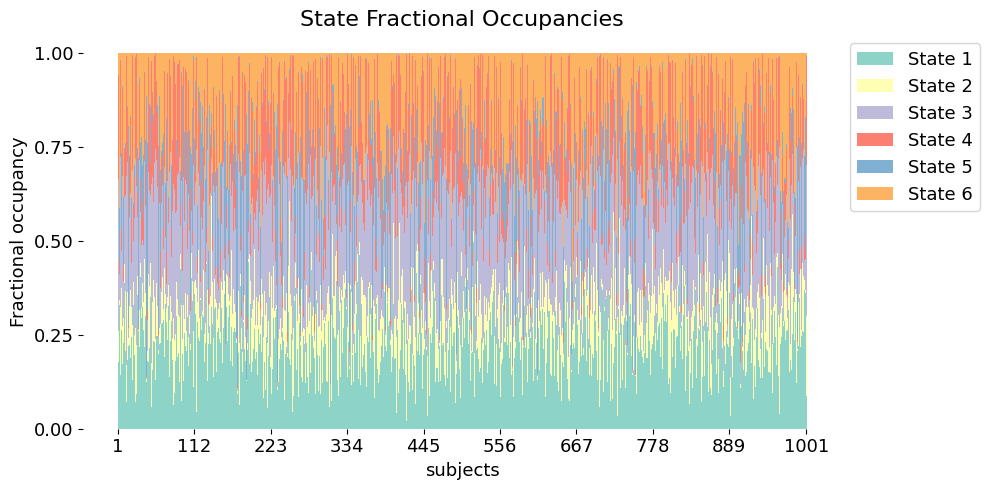

In [7]:
graphics.plot_FO(FO,num_ticks=10, xlabel="subjects", width=1, figsize=(10,5))

## 2. Across-subjects testing <a id="across_subjects"></a>

Next, we'll explore how to use the across_subjects function to uncover relationships between FO ($D$) from our brain data and behavioral variables ($R$) through permutation testing.

**Permutation testing**\
Permutation testing does not assume any particular data distribution and the procedure shuffles the data around to create a null distribution. This null distribution comes in handy for testing our hypotheses without making any assumptions about the data.
This null distribution becomes our benchmark to test the question: is there any real difference or relationship between the variables we're interested in?


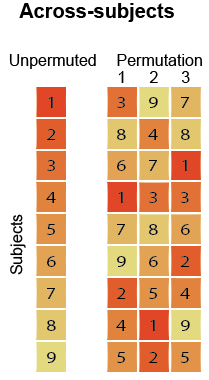

 **Figure 5A**: A 9 x 4 matrix representing permutation testing across subjects. Each row corresponds to a subject, with one observation each. The first column: displays the original index of each subject (perm=0). Next columns: examples of permuted subject indices.



### Family structure <a id="fam-struc"></a>
By default, the ```test_across_subjects``` function assumes that all subjects are independent and can be shuffled freely during permutation testing. However, in reality, familial connections between subjects may exist and can therefore violate the assumption that each subject are independent from each other. 

To address this, an Exchangeability Block (EB) file (```EB.csv```) is created. This file groups related subjects into blocks (e.g., families), allowing entire families to be shuffled together during permutation testing. For more details on this method, see [Winkler et al, 2015](https://www.sciencedirect.com/science/article/pii/S105381191500508X?via%3Dihub). A step-by-step tutorial for creating an ```EB.csv``` file from the HCP dataset is available in the notebook [HCP_multi_level_block_permutation.ipynb](./HCP_multi_level_block_permutation.ipynb).

When incorporating family structure into the ```test_across_subjects``` function, you'll use a dictionary (```dict_fam```) to specify the location of the ```EB.csv``` file. In this tutorial, we'll use default options and provide the file path for the family structure data.

In [8]:
dict_fam = {
    'file_location': 'EB.csv',  # Specify the file location of the family structure data
    # 'file_location': r'C:\Users\...\EB.csv'
}

### Across subjects - Multivariate <a id="perm_multivariate"></a>

The multivariate analysis aims to evaluate how variations in brain activity ($D$, represented by FO) relate to differences in behavioral measurements ($R$, such as sex and age). By considering multiple brain states simultaneously, this analysis assesses whether changes in FO contribute to explaining variability in the behavioral data.

If the results are significant, it suggests that specific patterns in FO are important for explaining the observed differences in behavioral measurements related to sex and age. Conversely, a non-significant result indicates that the variability in behavioral data may not be explained by the observed brain activity patterns.

To run the test_across_subjects test, we set the following parameters:

**Inputs:**

* ```D_data```: The state fractional occupancies (FO).
* ```R_data```: The behavioral measurements (e.g., sex and age).

**Settings:**
* ```method``` = "multivariate": Specifies that the test should perform pairwise correlation analysis.
* ```dict_fam```: Information about family structure for the subjects.

Additional settings allow for confounding variables to be accounted for during permutation testing. For details on these options, refer to the function documentation.

In [ ]:
# Set the parameters for between-subject testing
method = "multivariate"
Nnull_samples = 10_000 # Number of permutations (default = 0)
test_statistic_options = True
# Perform across-subject testing
result_multivariate  =statistics.test_across_subjects(D_data=FO, 
                                                      R_data=data_behavioral, 
                                                      method=method,Nnull_samples=Nnull_samples,
                                                      dict_family=dict_fam)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [00:01<00:00, 5597.59it/s]


What we can see here is that ```result_multivariate``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array holds the p-values resulting from the permutation test. Each value corresponds to a behavioral variable and will have shape of 1 by q, see [GLHMM paper](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python).

* ```base_statistics```: Stores the base statistics of the tests. In this case it is the explained variance $R^2$

* ```test_statistic```: Will by default always return a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```statistical_measures```: A dictionary that marks the units used as test_statistics

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_subjects```.

* ```method```: Specifies the analytical method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing.

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```Nnull_samples```: Is the number of permutations that has been performed.

* ```test_summary```: A dictionary summarizing the test results based on the applied method.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

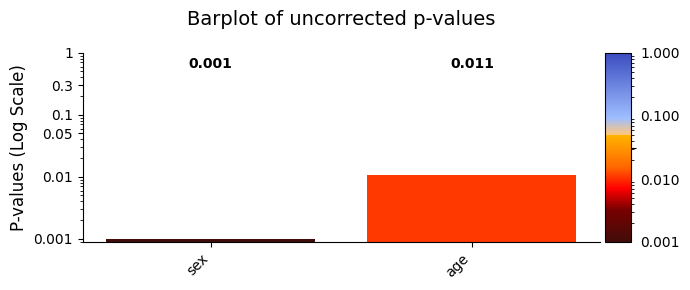

In [11]:
# Plot p-values
xticklabels=["sex","age"] 
graphics.plot_p_values_bar(result_multivariate["pval"], title_text ="Barplot of uncorrected p-values",
                      figsize=(7, 3), alpha=0.05, xticklabels=xticklabels)

**Multiple Comparison**\
Applying p-value correction using Benjamini/Hochberg to take into account the risk of type 1 errors (false positive) when doing to multiple testing.

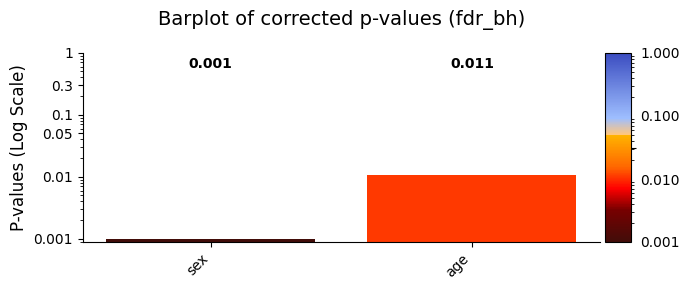

In [12]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_multivariate["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected, title_text ="Barplot of corrected p-values (fdr_bh)",
                      figsize=(7, 3), alpha=0.05, xticklabels=xticklabels)

**Extra**\
Now we can try to apply FWER correction directly as a multiple compartion test while doing the permutation testing

In [ ]:
# Set the parameters for between-subject testing
method = "multivariate"
Nnull_samples = 10_000 # Number of permutations (default = 0)
test_statistic_options = True
FWER = True
# Perform across-subject testing
result_regression_FWER  =statistics.test_across_subjects(D_data=FO, 
                                                         R_data=data_behavioral, 
                                                         method=method,
                                                         Nnull_samples=Nnull_samples, 
                                                         dict_family=dict_fam, 
                                                         FWER_correction=FWER)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [00:01<00:00, 5754.79it/s]


Plot FWER corrected p-values

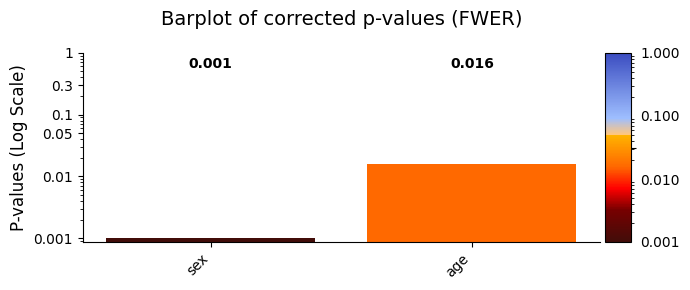

In [14]:
graphics.plot_p_values_bar(result_regression_FWER["pval"], title_text ="Barplot of corrected p-values (FWER)",
                      figsize=(7, 3), alpha=0.05, xticklabels=xticklabels)

**Conclusion - Multivariate test**\
The multivariate test revealed significant differences in FO for both 'sex' and 'age.' This indicates that variations in brain states collectively contribute to explaining the observed differences in these behavioral measurements.



### Across subjects - Univariate <a id="perm_univariate"></a>
The univariate analysis evaluates pairwise relationships between individual brain states ($D$, represented by FO) and behavioral measurements ($R$, such as sex and age). This approach assesses how strongly each brain state is associated with each behavioral measurement independently, focusing on one pair of variables at a time.

If the results are significant, it suggests that the brain’s response to a specific behavioral measurement is consistently related across subjects. A non-significant result indicates that the observed relationships might be due to random chance.

To run the across_subjects test, we set the following parameters:

**Inputs:**

* ```D_data```: The state fractional occupancies (FO).
* ```R_data```: The behavioral measurements (e.g., sex and age).

**Settings:**
* ```method``` = "correlation": Specifies that the test should perform pairwise correlation analysis.
* ```dict_fam```: Information about family structure for the subjects.

Additional settings allow for confounding variables to be accounted for during permutation testing. For details on these options, refer to the function documentation.

In [ ]:
# Set the parameters for between-subject testing
method = "univariate"
Nnull_samples = 10_000 # Number of permutations (default = 0)
test_statistic_option=True
# Perform across-subject testing
result_univariate  =statistics.test_across_subjects(D_data=FO, 
                                                    R_data=data_behavioral, 
                                                    method=method,Nnull_samples=Nnull_samples,
                                                    dict_family=dict_fam)


Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [00:02<00:00, 4756.43it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value and correlation matrix.\
We will import the function ```plot_heatmap``` from module ```helperfunctions.py```

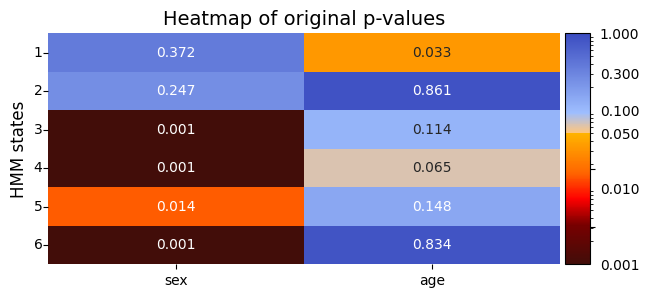

In [17]:
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_p_value_matrix(result_univariate["pval"], title_text ="Heatmap of original p-values",
                      figsize=(7, 3), ylabel="HMM states", alpha=alpha, 
                      xticklabels=xticklabels,normalize_vals=True, annot=True)

**Visualization correlation coefficients (base statistics)**\
Now we can look at the correlation coefficients between the HMM states and the corresponding behavioral parameters "sex" and "age".

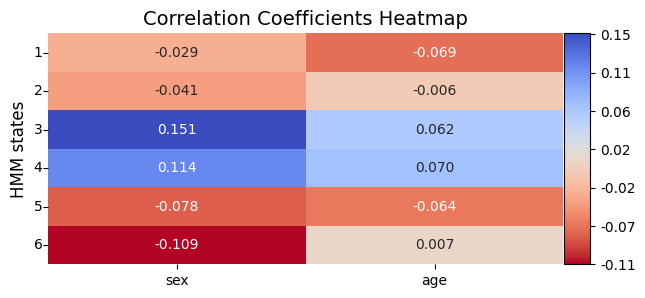

In [18]:
# Plot p-values
alpha=0.05 # p-value threshold
graphics.plot_correlation_matrix(result_univariate["base_statistics"], result_univariate["statistical_measures"],
                      figsize=(7, 3), ylabel="HMM states", 
                      xticklabels=xticklabels, annot=True)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

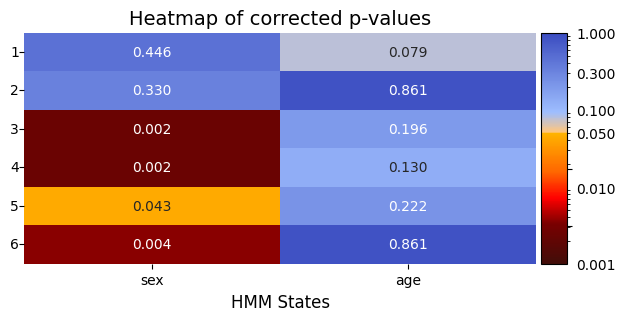

In [19]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(7, 3), 
                             xlabel="HMM States", ylabel="", annot=True, xticklabels=xticklabels)

**Extra**\
Now we can try to apply FWER correction directly as a multiple compartion test while doing the permutation testing

In [ ]:
# Set the parameters for between-subject testing
method = "univariate"
Nnull_samples = 10_000 # Number of permutations (default = 0)
FWER = True
# Perform across-subject testing
result_univariate_FWER  =statistics.test_across_subjects(FO, data_behavioral, 
                                                         method=method,
                                                         Nnull_samples=Nnull_samples,
                                                         dict_family=dict_fam,
                                                         FWER_correction=FWER)

Number of possible permutations is exp(1586.6248450207656).
Generating 10000 shufflings (permutations only).


100%|██████████| 10000/10000 [00:02<00:00, 4808.36it/s]


Plot p-values

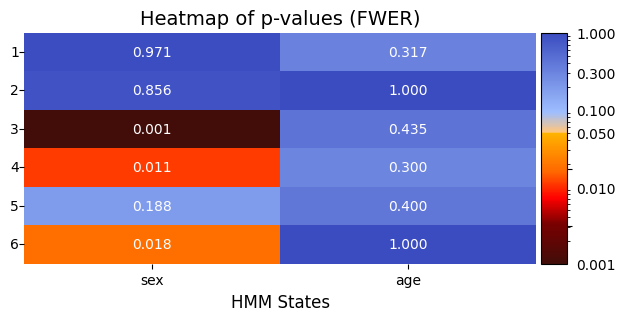

In [21]:
# Plot p-values
graphics.plot_p_value_matrix(result_univariate_FWER["pval"], title_text ="Heatmap of p-values (FWER)",
                             figsize=(7, 3), xlabel="HMM States", ylabel="", annot=True, xticklabels=xticklabels)

**Plot permutation distribution**\
Presented here are the significant test statistics of our permutation distributionfor the different states.
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

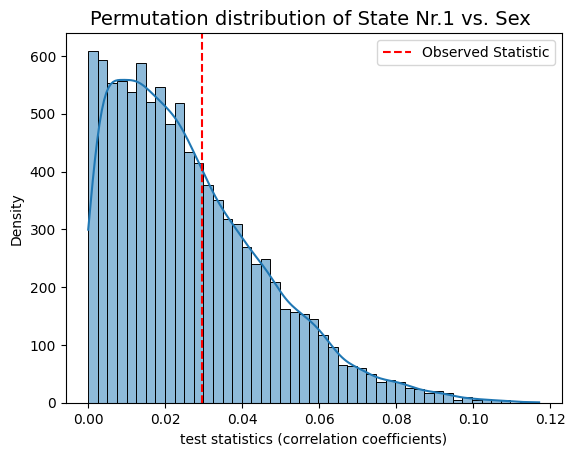

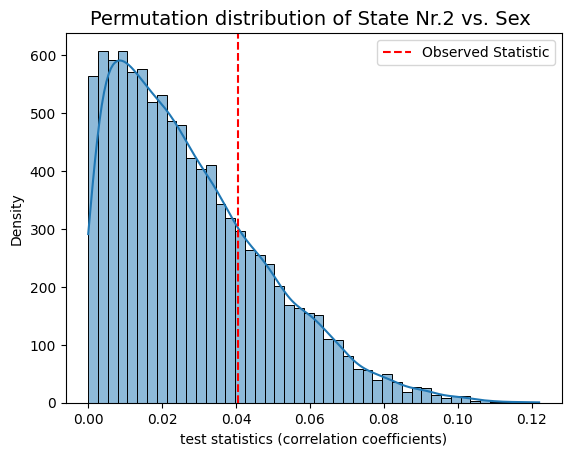

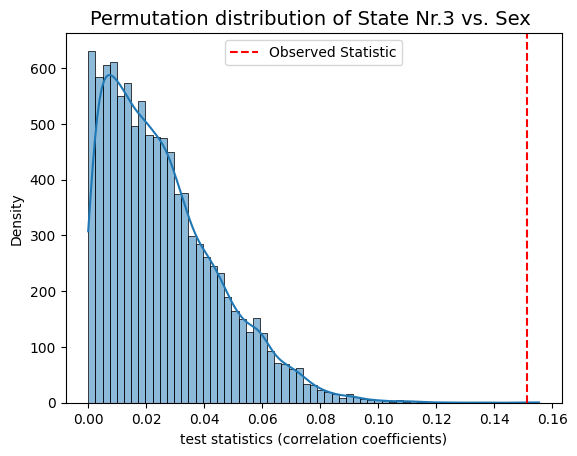

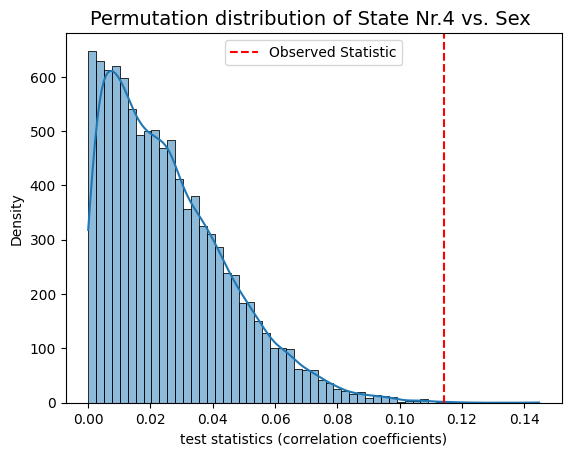

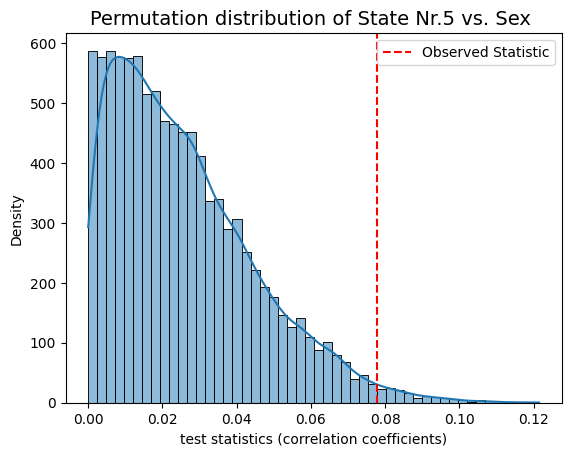

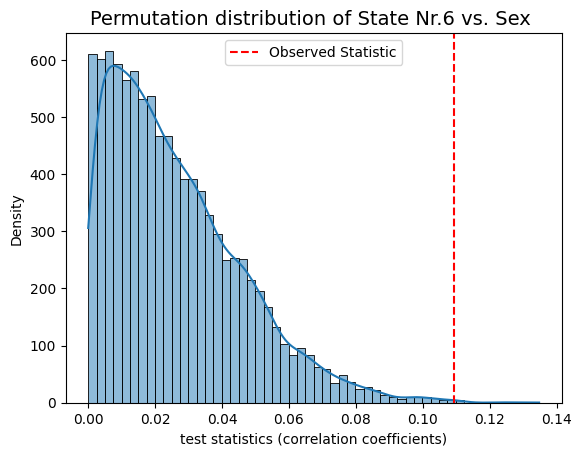

In [22]:
# Plot test statistics for pvals
column_pos =0 # Sex is in column position 0 
xlabel = "test statistics (correlation coefficients)"
#significant_timestamp_position = np.where(pval_corrected< alpha)

# Visualizing the permutation distribution for sex, which got index=0
for i in range(result_univariate["test_statistics"].shape[1]):
    graphics.plot_permutation_distribution(result_univariate["test_statistics"][:,i,column_pos],title_text=f"Permutation distribution of State Nr.{i+1} vs. Sex ", xlabel=xlabel )

### Conclusion - Univariate
After applying multiple comparison correction, the univariate test reveals significant differences in FO for states 3, 4, and 6 with respect to 'sex' after correcting for FWER. However, no significant differences were observed for any states in 'age.'

This discrepancy arises because the multivariate test considers the combined contribution of all states to explain the variability in behavioral measurements, capturing subtle, collective effects. In contrast, the univariate test examines each state individually. For 'age,' the variability may be distributed across multiple states, making it undetectable in the pairwise comparisons conducted in the univariate test after correction. This highlights the complementary strengths of the two approaches in analyzing complex relationships.